# Initialization. Load previous state. Load modules

In [1]:
import dill
# Restore the entire session
#dill.load_session('PTRMS_tun_class_all.db')

In [2]:
#check last result on disk
#dir()

In [3]:
import json

import pandas as pd
import numpy as np
import numpy as cp
#import cupy as cp

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC

from finetuning_scripts.finetune_tabpfn_main import fine_tune_tabpfn
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [4]:
#PLS-DA, implemented using sklearn PLS and PDA functions
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class PLSDA_Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=2):
        """
        A classifier that combines PLS for dimensionality reduction
        followed by LDA for classification.
        
        Parameters:
        ----------
        n_components: int
            Number of PLS components to use.
        """
        self.n_components = n_components
    
    def fit(self, X, y):
        """
        Fit the PLSDA classifier.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data.

        y : array-like, shape (n_samples,)
            Target labels.
        """
        # Validate input
        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        
        # Fit the PLS for dimensionality reduction
        self.pls_ = PLSRegression(n_components=self.n_components)
        X_reduced = self.pls_.fit(X, y).x_scores_

        # Fit the LDA for classification
        self.lda_ = LinearDiscriminantAnalysis()
        self.lda_.fit(X_reduced, y)
        
        return self

    def predict(self, X):
        """
        Predict labels for given data.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        -------
        y_pred : array, shape (n_samples,)
            Predicted labels.
        """
        # Check if the model is fitted
        check_is_fitted(self, ["pls_", "lda_"])
        
        # Transform the data with PLS
        X = check_array(X)
        X_reduced = self.pls_.transform(X)
        
        # Predict using LDA
        return self.lda_.predict(X_reduced)

    def predict_proba(self, X):
        """
        Predict class probabilities for X.

        Parameters:
        ----------
        X : array-like, shape (n_samples, n_features)
            Input data.

        Returns:
        -------
        proba : array, shape (n_samples, n_classes)
            Predicted probabilities.
        """
        # Check if the model is fitted
        check_is_fitted(self, ["pls_", "lda_"])
        
        # Transform the data with PLS
        X = check_array(X)
        X_reduced = self.pls_.transform(X)
        
        # Predict probabilities using LDA
        return self.lda_.predict_proba(X_reduced)


In [5]:
def finetunemymodel(X, y, param_grid , verbose=False, time_limit=60, learning_rate=0.0000002, batch_size=5):
    #X_train, X_test, y_train, y_test = train_test_split(
    #    X,
    #    y,
    #    test_size=0.33
    #)


    save_path_to_fine_tuned_model = param_grid.get("model_path")
    fine_tune_tabpfn(
        path_to_base_model="auto",
        save_path_to_fine_tuned_model=save_path_to_fine_tuned_model,
        # Finetuning HPs
        time_limit=time_limit,
        finetuning_config={"learning_rate": learning_rate, "batch_size": batch_size},
        validation_metric="log_loss",
        # Input Data
        #X_train=X_train,
        #y_train=y_train,
        X_train=pd.DataFrame(X),
        y_train=pd.Series(y),
        categorical_features_index=None,
        device=param_grid.get('device'), 
        task_type="multiclass",
        # Optional
        show_training_curve=True,  # Shows a final report after finetuning.
        logger_level=0,  # Shows all logs, higher values shows less
        use_wandb=False,  # Init wandb yourself, and set to True
    )


In [6]:
def predict_class_by_label(IDs, y, X, classifier, param_grid={}, cv=5, gpu=False, verbose=True):
    """
    Calculates predictions for test sets, each with a unique label in IDs, and selects the best parameters using GridSearchCV.

    Args:
        IDs: A pandas Series containing labels.
        y: A pandas Series or numpy array containing target labels.
        X: A pandas DataFrame or numpy array containing features.
        classifier: A scikit-learn classifier class.
        param_grid: A dictionary specifying parameter options for GridSearchCV.
        cv: Number of folds for cross-validation. If cv=0 it directly tunes a single model
        gpu: If True, move X to gpu before training.
        verbose: If True, prints progress and metrics.

    Returns:
        predictions: Predictions for y as test sets.
        classification error.
        best_params_per_label: Dictionary with the best parameters for each label.
    """
    unique_labels = IDs.unique()
    best_params_per_label = {}
    
    # Ensure X and y are numpy arrays for compatibility
    #if not isinstance(X, np.ndarray):
    #    X = X.to_numpy()
    #if not isinstance(y, np.ndarray):
    #    y = y.to_numpy()

    predictions = y[:]*0

    for label in unique_labels:
        mask = (IDs == label)
            
        if gpu:
            X_train, X_test = cp.array(X[~mask]), cp.array(X[mask])
        else:
            X_train, X_test = X[~mask], X[mask]            
        y_train, y_test = y[~mask], y[mask]
        
        if cv>1:
            # Use GridSearchCV to find the best parameters
            grid_search = GridSearchCV(
                estimator=classifier(),
                param_grid=param_grid,
                scoring='accuracy',
                cv=cv,
                verbose=verbose
            )
            grid_search.fit(X_train, y_train)
            best_model = grid_search.best_estimator_

            # Store the best parameters
            best_params_per_label[label] = grid_search.best_params_

        else:
            #fine tune tabPFN if selected
            if classifier is TabPFNClassifier and param_grid.get("model_path","auto") != "auto":
                finetunemymodel(X_train,y_train,param_grid,verbose)
            best_model = classifier(**param_grid)
            best_model.fit(X_train, y_train)
            best_params_per_label[label] = param_grid
    
        # Predict on the test set
        predictions[mask] = best_model.predict(X_test)
 
        if verbose:
            print(f"Label: {label}, Best Params: {best_params_per_label[label]}")
            print(f"Test Set error for label {label}: {round(1.0-accuracy_score(y_test, predictions[mask]), 4)}")

    # Final metrics
    final_error = 1.0-accuracy_score(y, predictions)
    
    if verbose:
        print(f"\nOverall Classification Error: {round(final_error, 4)}")

    return predictions, final_error, best_params_per_label


# Load datasets froms json file

In [7]:
# Load data from JSON
with open('data_classif.json', 'r') as json_file:
    loaded_datasets = json.load(json_file)


In [7]:
# Load data from JSON
with open('data_gc_classif.json', 'r') as json_file:
    loaded_datasets = json.load(json_file)


In [7]:
# Load data from JSON
with open('data_classif_breath.json', 'r') as json_file:
    loaded_datasets = json.load(json_file)


# Train methods

In [9]:
"""
#Debugge warnings

import warnings
import traceback

def mostrar_warning(message, category, filename, lineno, file=None, line=None):
    print(f"¡Warning Capturado!: {message} ({filename}:{lineno})")
    traceback.print_stack()

warnings.showwarning = mostrar_warning
"""


'\n#Debugge warnings\n\nimport warnings\nimport traceback\n\ndef mostrar_warning(message, category, filename, lineno, file=None, line=None):\nprint(f"¡Warning Capturado!: {message} ({filename}:{lineno})")\ntraceback.print_stack()\n\nwarnings.showwarning = mostrar_warning\n'

## All datasets

Etnia-PDA: 0.4416
Etnia-tabPFN: 0.2727


Fine-tuning Steps:   0%| | 26/10000 [00:12<1:24:14,  1.97it/s, Best Val. Loss=0.588, Best Val. Score=-0.588, T
/home/granitto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


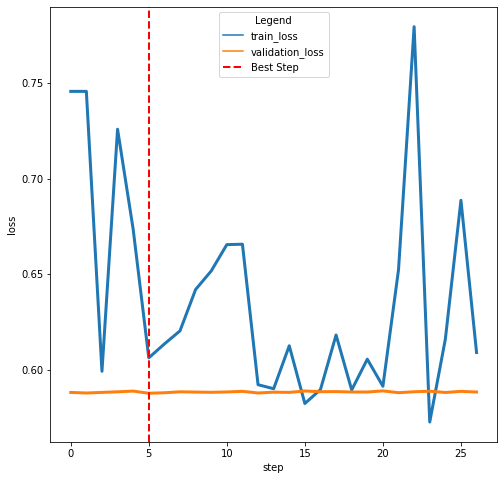

Fine-tuning Steps:   0%| | 21/10000 [00:09<1:16:15,  2.18it/s, Best Val. Loss=0.541, Best Val. Score=-0.541, T


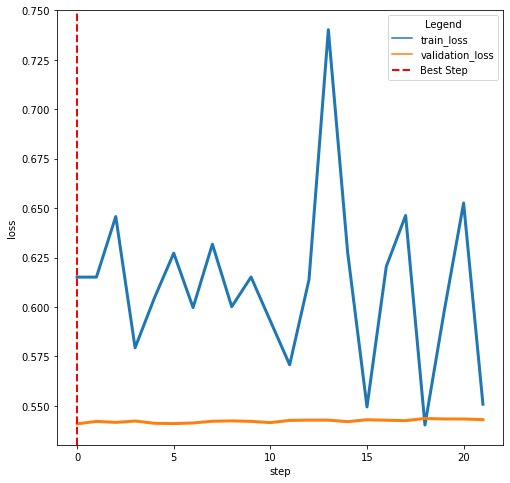

Fine-tuning Steps:   0%| | 21/10000 [00:09<1:16:53,  2.16it/s, Best Val. Loss=0.552, Best Val. Score=-0.552, T


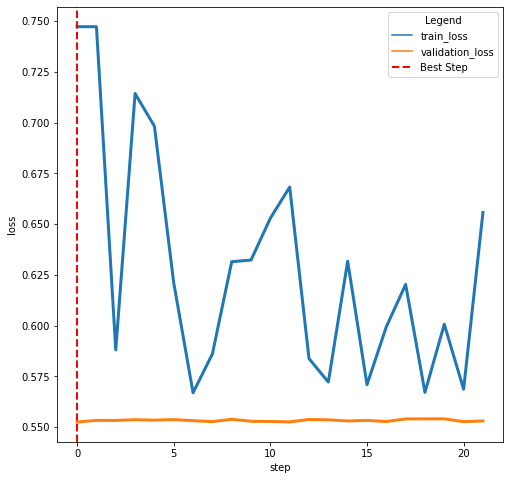

Fine-tuning Steps:   0%| | 35/10000 [00:17<1:23:21,  1.99it/s, Best Val. Loss=0.585, Best Val. Score=-0.585, T


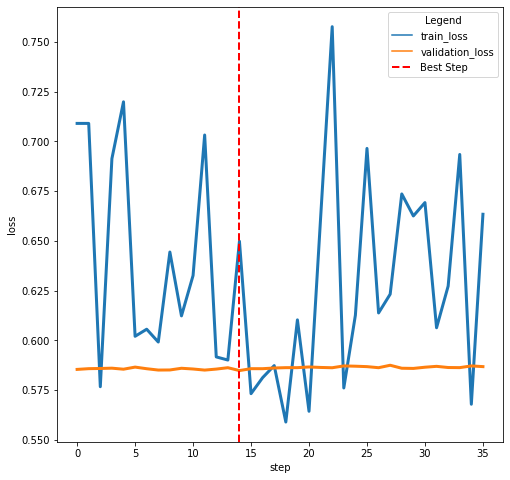

Fine-tuning Steps:   0%| | 38/10000 [00:19<1:25:21,  1.95it/s, Best Val. Loss=0.634, Best Val. Score=-0.634, T


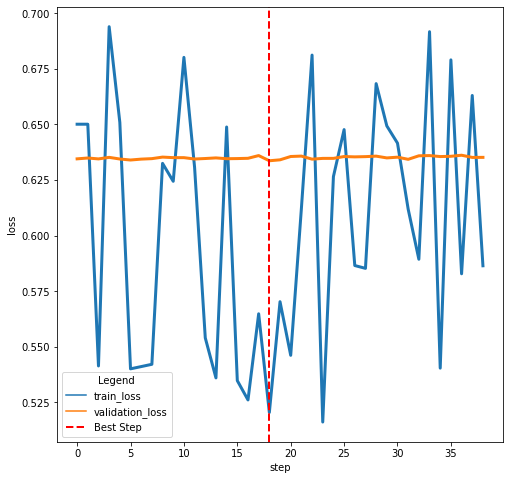

Fine-tuning Steps:   0%| | 26/10000 [00:12<1:20:32,  2.06it/s, Best Val. Loss=0.598, Best Val. Score=-0.598, T


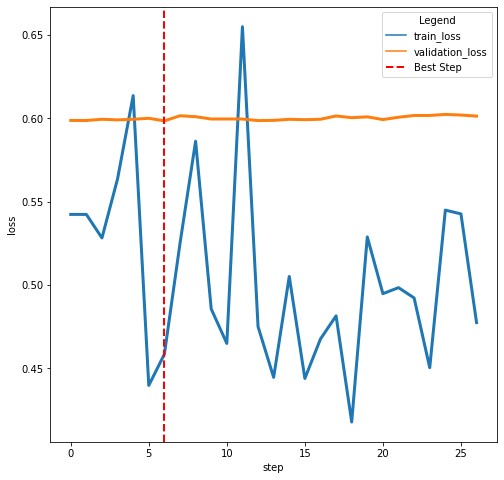

Fine-tuning Steps:   0%| | 34/10000 [00:16<1:23:59,  1.98it/s, Best Val. Loss=0.538, Best Val. Score=-0.538, T


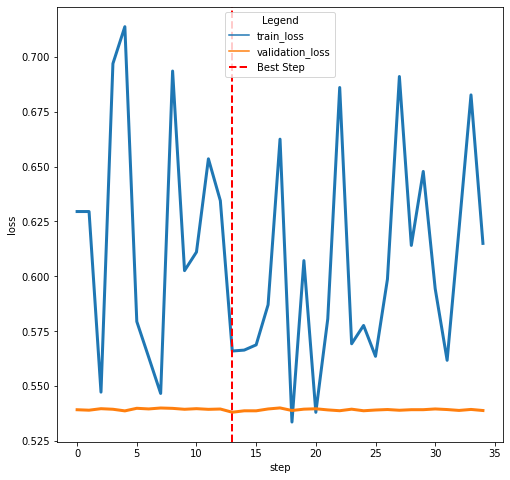

Fine-tuning Steps:   1%| | 99/10000 [00:58<1:38:43,  1.67it/s, Best Val. Loss=0.483, Best Val. Score=-0.483, T


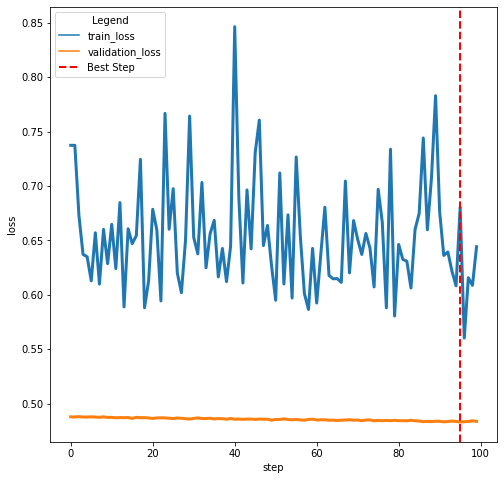

Fine-tuning Steps:   1%| | 111/10000 [00:58<1:28:19,  1.87it/s, Best Val. Loss=0.479, Best Val. Score=-0.479, 


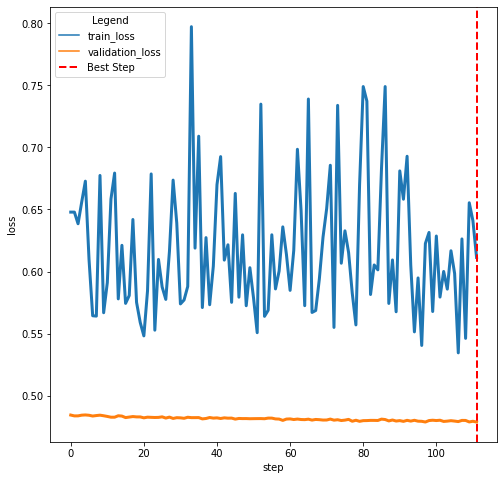

Fine-tuning Steps:   1%| | 86/10000 [00:45<1:28:12,  1.87it/s, Best Val. Loss=0.511, Best Val. Score=-0.511, T


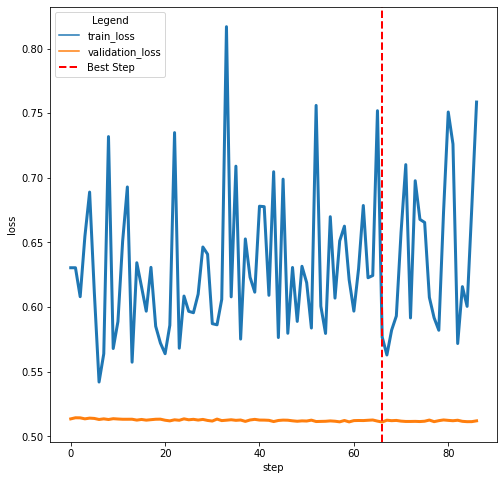

Fine-tuning Steps:   1%| | 61/10000 [00:31<1:27:24,  1.90it/s, Best Val. Loss=0.461, Best Val. Score=-0.461, T


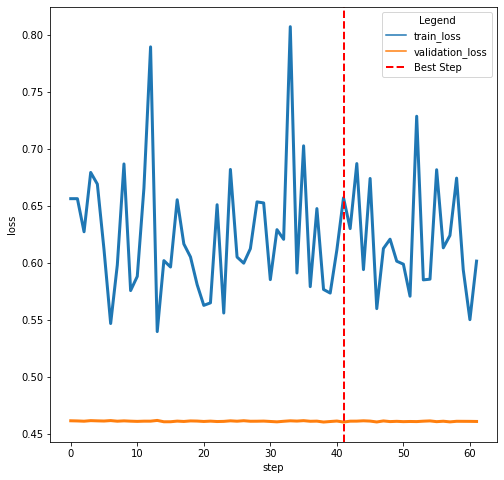

Fine-tuning Steps:   0%| | 32/10000 [00:14<1:19:06,  2.10it/s, Best Val. Loss=0.5, Best Val. Score=-0.5, Train


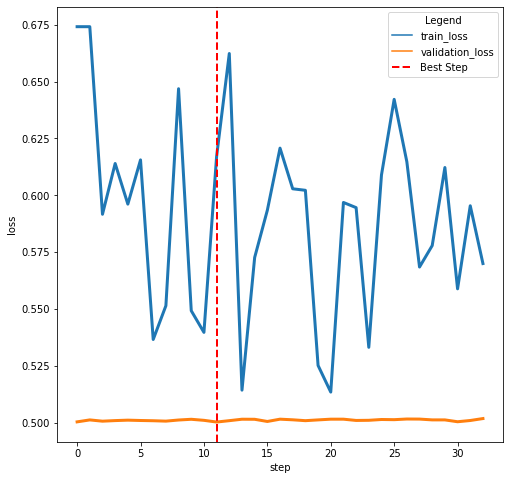

Fine-tuning Steps:   0%| | 34/10000 [00:18<1:33:53,  1.77it/s, Best Val. Loss=0.563, Best Val. Score=-0.563, T


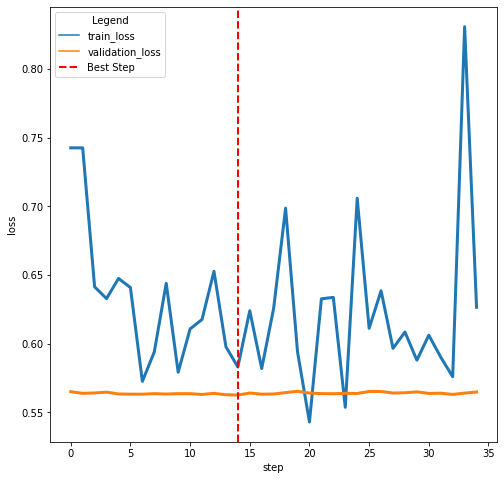

Fine-tuning Steps:   0%| | 36/10000 [00:18<1:27:27,  1.90it/s, Best Val. Loss=0.527, Best Val. Score=-0.527, T


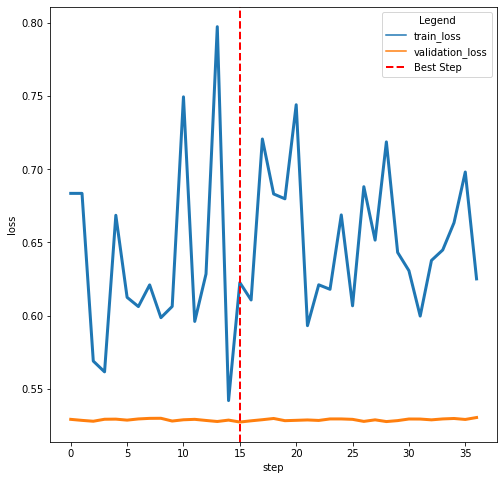

Fine-tuning Steps:   0%| | 21/10000 [00:10<1:23:59,  1.98it/s, Best Val. Loss=0.564, Best Val. Score=-0.564, T


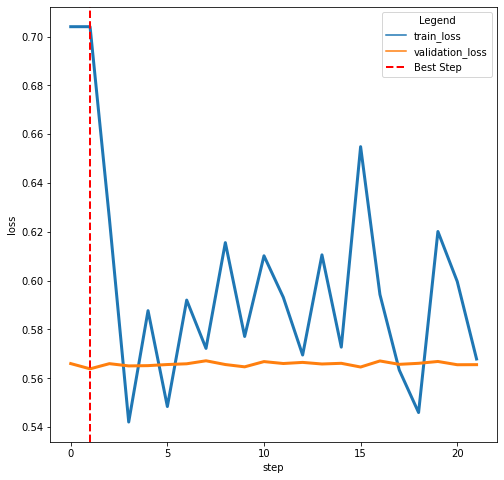

Fine-tuning Steps:   0%| | 26/10000 [00:12<1:24:23,  1.97it/s, Best Val. Loss=0.493, Best Val. Score=-0.493, T


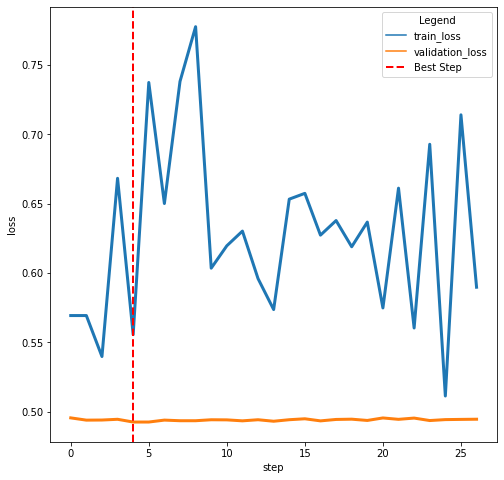

Fine-tuning Steps:   1%| | 104/10000 [00:59<1:34:45,  1.74it/s, Best Val. Loss=0.575, Best Val. Score=-0.575, 


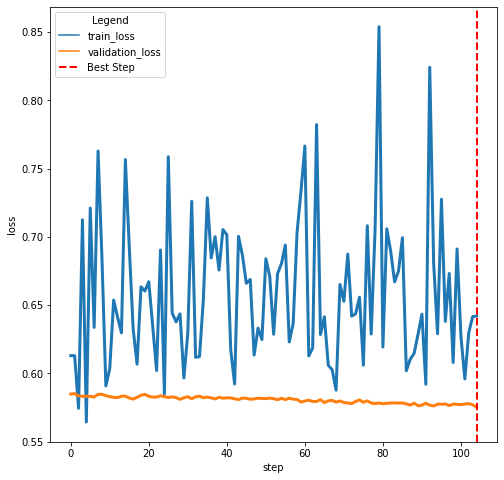

Fine-tuning Steps:   1%| | 82/10000 [00:41<1:25:37,  1.93it/s, Best Val. Loss=0.54, Best Val. Score=-0.54, Tra


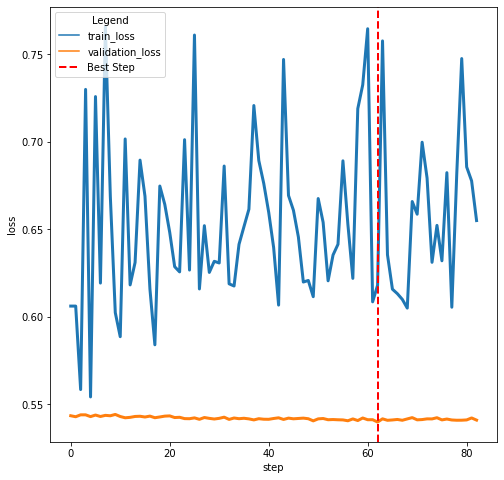

Fine-tuning Steps:   1%| | 76/10000 [00:40<1:30:18,  1.83it/s, Best Val. Loss=0.524, Best Val. Score=-0.524, T


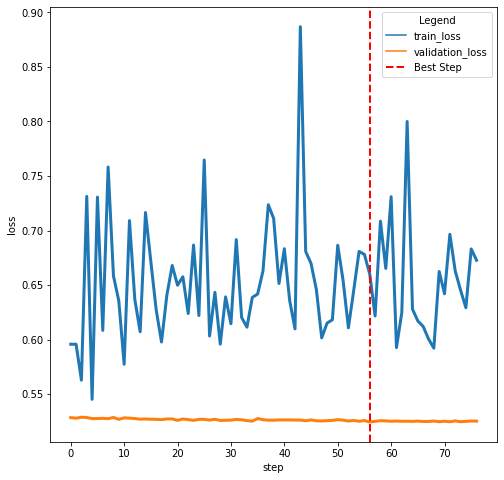

Fine-tuning Steps:   0%| | 40/10000 [00:20<1:26:33,  1.92it/s, Best Val. Loss=0.538, Best Val. Score=-0.538, T


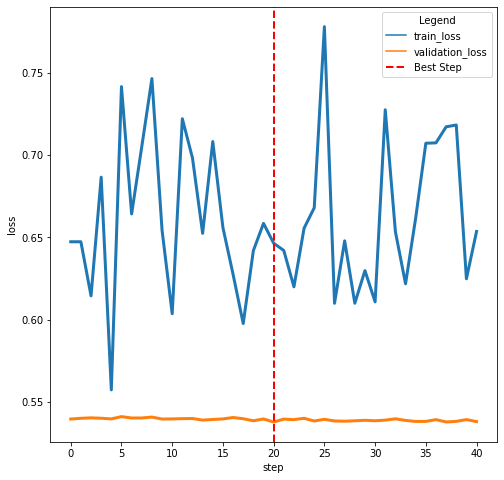

Fine-tuning Steps:   1%| | 56/10000 [00:29<1:27:28,  1.89it/s, Best Val. Loss=0.494, Best Val. Score=-0.494, T


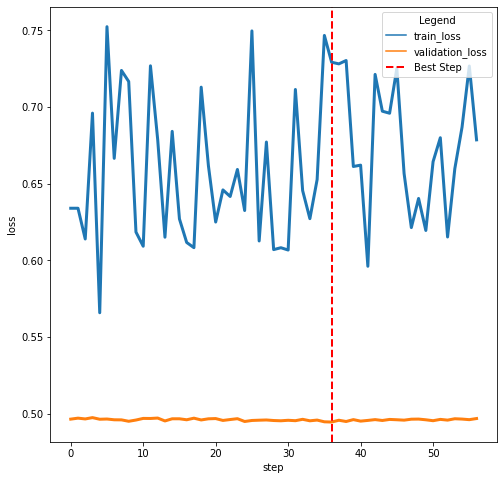

Fine-tuning Steps:   1%| | 110/10000 [00:59<1:29:14,  1.85it/s, Best Val. Loss=0.484, Best Val. Score=-0.484, 


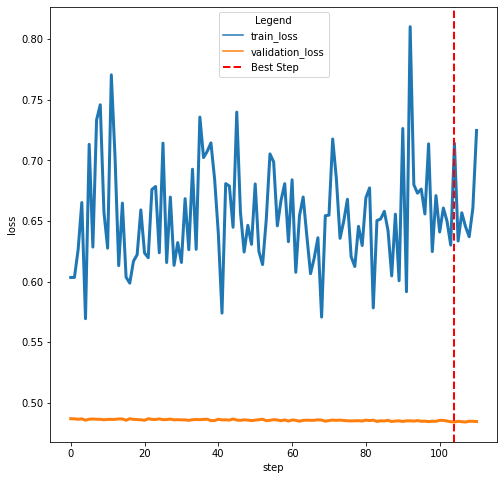

Fine-tuning Steps:   0%| | 27/10000 [00:13<1:28:47,  1.87it/s, Best Val. Loss=0.441, Best Val. Score=-0.441, T


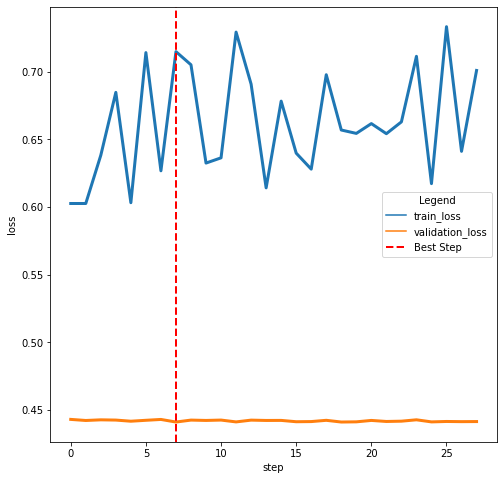

Fine-tuning Steps:   1%| | 55/10000 [00:29<1:30:06,  1.84it/s, Best Val. Loss=0.502, Best Val. Score=-0.502, T


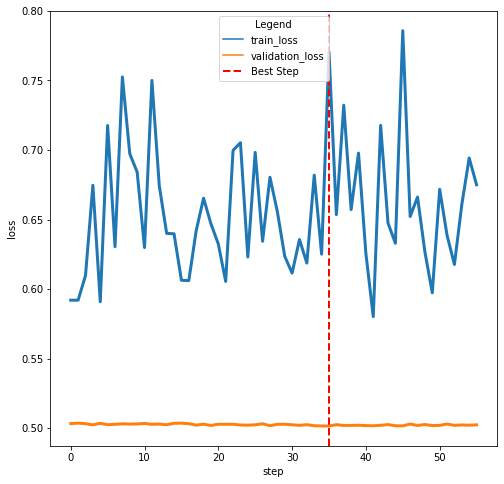

Fine-tuning Steps:   1%| | 105/10000 [00:58<1:33:08,  1.77it/s, Best Val. Loss=0.506, Best Val. Score=-0.506, 


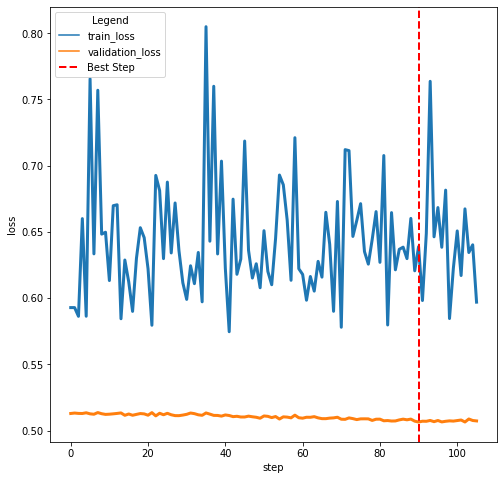

Fine-tuning Steps:   1%| | 73/10000 [00:40<1:33:42,  1.77it/s, Best Val. Loss=0.52, Best Val. Score=-0.52, Tra


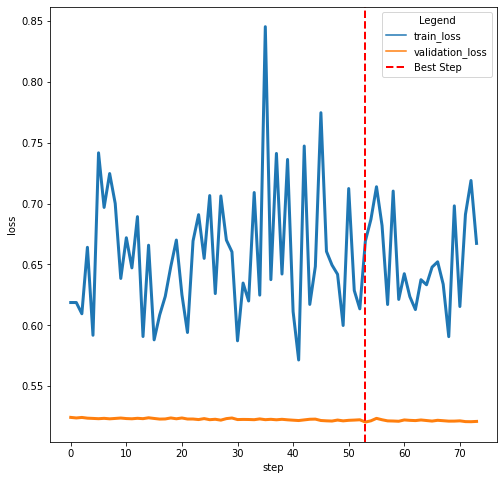

Fine-tuning Steps:   1%| | 112/10000 [00:59<1:27:47,  1.88it/s, Best Val. Loss=0.514, Best Val. Score=-0.514, 


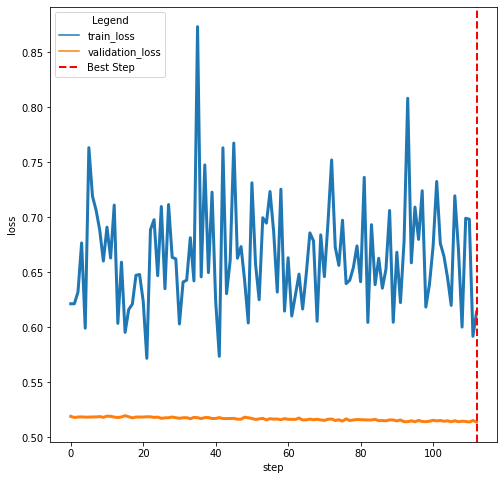

Fine-tuning Steps:   1%| | 103/10000 [00:54<1:27:20,  1.89it/s, Best Val. Loss=0.486, Best Val. Score=-0.486, 


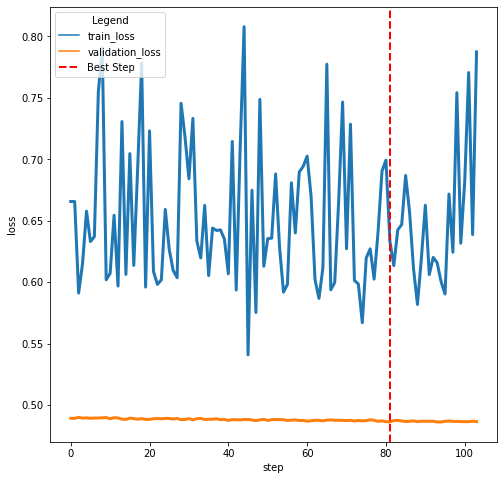

Fine-tuning Steps:   1%| | 109/10000 [00:58<1:29:48,  1.84it/s, Best Val. Loss=0.488, Best Val. Score=-0.488, 


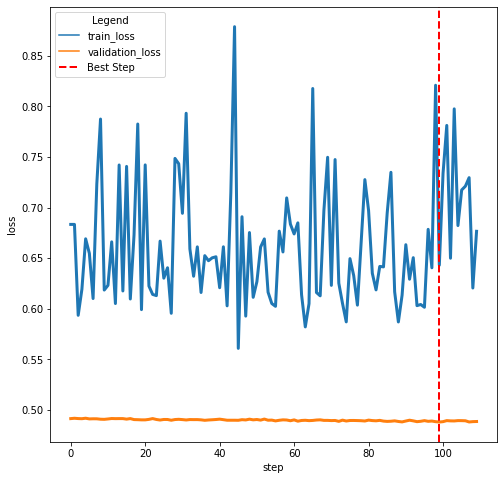

Etnia-finetune_tabPFN: 0.2727


In [8]:
#PTRMS
#datasets = ["Tea", "Gum2", "Gum3", "Cafe", "Ham", "Pesce", "Spinaci", "Peperoncini", "Funghi13", "Funghi20", "Funghi21","Urine","Smoker","CancerTypes","Lab"]
#GC
#datasets = ["Funghi", "Peperoncini", "Spinaci", "Fragole","Nocciole"]
#datasets = ["Mentine","Forest","Etnia"]

datasets = ["Etnia"]

# Dictionary to store results
results = {dataset: {} for dataset in datasets}

# Define model parameters

models = {
    "RF": {
        "classifier": RandomForestClassifier,
        "param_grid": {
            'n_estimators': 1000,
            'max_features': 'sqrt'
        },
        "cv": 0,
        "gpu": False
    },
    "PDA": {
        "classifier": LinearDiscriminantAnalysis,
        "param_grid": {
            'solver':'lsqr', 
            'shrinkage':'auto'
        },
        "cv": 0,
        "gpu": False
    },
    "XGB": {
        "classifier": XGBClassifier,
        "param_grid": {
            'device': ['cpu'],
            'n_estimators': [1000], 
            'eta': [0.25,0.10,0.05], 
            'max_depth': [1,3,5], 
            'subsample': [1,0.8,0.6], 
            'colsample_bytree': [1,0.75,0.5]
        },
        "cv": 3,
        "gpu": False
    },
    "SVM": {
        "classifier": SVC,
        "param_grid": {
            'kernel':['linear'],
            'C':[0.01,0.1,1.0,10,100,1000,10000,100000],
            'degree':[3],
            'gamma':['scale']
        },
        "cv": 3,
        "gpu": False
    },
    "PLS-DA": {
        "classifier": PLSDA_Classifier,
        "param_grid": {
            'n_components':[2,3,4,5,6,7,8]
        },
        "cv": 3,
        "gpu": False
    },
    "tabPFN": {
        "classifier": TabPFNClassifier,
        "param_grid": {
            'model_path': 'Auto',
            'device': 'cuda',
            'ignore_pretraining_limits':True
        },
        "cv": 0,
        "gpu": False
    }
}

models = {
    "PDA": {
        "classifier": LinearDiscriminantAnalysis,
        "param_grid": {
            'solver':'lsqr', 
            'shrinkage':'auto'
        },
        "cv": 0,
        "gpu": False
    },
    "tabPFN": {
        "classifier": TabPFNClassifier,
        "param_grid": {
            'model_path': 'auto',
            'device': 'cuda',
            'ignore_pretraining_limits':True
        },
        "cv": 0,
        "gpu": False
    },
    "finetune_tabPFN": {
        "classifier": TabPFNClassifier,
        "param_grid": {
            'model_path': './tuneada.ckpt',
            'device': 'cuda',
            'ignore_pretraining_limits':True
        },
        "cv": 0,
        "gpu": False
    }
}



from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Loop through datasets
for dataset in datasets:
    this_data = loaded_datasets[dataset]
    
    IDs = pd.Series(this_data["IDs"])
    y = np.array(this_data["y"])
    X = pd.DataFrame(this_data["X"])
    columns_to_keep = X.columns
    X = pd.DataFrame(scaler.fit_transform(X) , columns=columns_to_keep)
    
    for model_name, model_info in models.items():
        predict = predict_class_by_label(
            cv=model_info["cv"], 
            gpu=model_info["gpu"], 
            IDs=IDs, 
            y=y, 
            X=X, 
            classifier=model_info["classifier"], 
            param_grid=model_info["param_grid"], 
            verbose=False
        )
        results[dataset][model_name] = predict
        print(f"{dataset}-{model_name}: {round(predict[1],4)}")

In [9]:
dill.dump_session('Finetune_breath_1.db')

In [10]:
# Print header
print("Dataset".ljust(12) + " | " + " | ".join(model_name.ljust(15) for model_name in models))

# Print separator line
print("-" * (12 + 3 + len(models) * 18))

# Print results
for dataset in datasets:
    result_line = f"{dataset.ljust(12)} | " + " | ".join(f"{round(results[dataset][model_name][1],4):<15}" for model_name in models)
    print(result_line)


Dataset      | PDA             | tabPFN          | finetune_tabPFN
---------------------------------------------------------------------
Etnia        | 0.4416          | 0.2727          | 0.2727         


In [11]:
print("---------------------------")
print("Confusion matrices")
print("---------------------------")

for dataset in datasets:
    this_data = loaded_datasets[dataset]    
    y = np.array(this_data["y"])
    for model_name in models:
        confusion_matrix = pd.crosstab(y, results[dataset][model_name][0], rownames=['Actual'], colnames=['Predicted'])
        # Print the confusion matrix with a title
        print(f"Confusion Matrix for {dataset}-{model_name}:")
        print(confusion_matrix)
        print("\n")  # Add a newline for better readability


---------------------------
Confusion matrices
---------------------------
Confusion Matrix for Etnia-PDA:
Predicted   0   1
Actual           
0          22  17
1          17  21


Confusion Matrix for Etnia-tabPFN:
Predicted   0   1
Actual           
0          27  12
1           9  29


Confusion Matrix for Etnia-finetune_tabPFN:
Predicted   0   1
Actual           
0          27  12
1           9  29


